# Full NN Build

## Setup general del experimento

In [48]:
params = {
    "learning_rate": 0.001,
    "momentum": 0.9,
    "acc": 0.0,
    "epoca": 0,
    "input_file": '/data/concentlite.csv',
    "EXP_NAME": 'EXP010',
    "MIN_ACC": 1.0,
    "MIN_ERROR": 1E6,
    "MAX_EPOCAS": 1000,
    "MAX_COUNTER": 50,
    "BATCH_SIZE": 20
}

In [49]:
import numpy as np
import os
import math
import time
import pandas as pd
import json
# NN
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from torch import optim
from copy import deepcopy
from sklearn.model_selection import train_test_split
## Ploting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
## Progress bar
from tqdm.notebook import tqdm
# Path
import sys
sys.path.append('/home/sebacastillo/neuralnets/')
from src.utils import get_project_root
root = get_project_root()
## Check torch version
print(f'Using {torch.__version__}')


Using 2.0.0+cu117


In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else torch.device('cpu'))
torch.manual_seed(42)
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [51]:
def load_split_save_data(input_filename, output_name='EXP', split_type='train_test', train_ratio=0.75, validate_ratio=None, test_ratio=None):

    data = pd.read_csv(input_filename)

    # Check if 'exp' folder exists, create it if it doesn't
    if not os.path.exists('exp'):
        os.makedirs('exp')
    
    # Create a subfolder with the output_name
    output_path = os.path.join('exp', output_name)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    if split_type == 'train_validate_test':
        if not validate_ratio or not test_ratio:
            raise ValueError("Please provide validate_ratio and test_ratio for 'train_validate_test' split type.")
        
        train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=42)
        validate_data, test_data = train_test_split(temp_data, train_size=validate_ratio / (validate_ratio + test_ratio), random_state=42)
        
        # Save the train, validate, and test data as CSV files in the output folder
        train_data.to_csv(os.path.join(output_path, f'{output_name}_train_data.csv'), index=False)
        validate_data.to_csv(os.path.join(output_path, f'{output_name}_validate_data.csv'), index=False)
        test_data.to_csv(os.path.join(output_path, f'{output_name}_test_data.csv'), index=False)


        return train_data, validate_data, test_data    

    elif split_type == 'train_test':
        train_data, test_data = train_test_split(data, train_size=train_ratio, random_state=42)
        
        # Save the train and test data as CSV files in the output folder
        train_data.to_csv(os.path.join(output_path, f'{output_name}_train_data.csv'), index=False)
        test_data.to_csv(os.path.join(output_path, f'{output_name}_test_data.csv'), index=False)


        return train_data, test_data
    
    else:
        raise ValueError("Invalid split_type. Use either 'train_validate_test' or 'train_test'.")



In [52]:
class DATASET(Dataset):  
    '''
    Esta clase maneja la lectura de los datos y provee un mecanismo
    para alimentar los modelos con los patrones.
    '''
    
    #===================================================
    def __init__(self, filename):
        
        #------------------------------------
        # LECTURA DE LOS DATOS
        data = pd.read_csv(filename, header=None).to_numpy() # Levanta los datos en formato numpy
        
        #------------------------------------
        # INSERTAMOS COLUMNA DEL "BIAS"
        #bias = -np.ones((len(data), 1))
        #data = np.concatenate((bias, data), axis=1)  # Insertamos el "bias" en la primera columna
        
        #------------------------------------
        # ALEATORIZO LOS PATRONES (filas)
        idxs = np.arange(len(data))  # Genero un vector de índices
        np.random.shuffle(idxs)
        data = data[idxs,:]
        
        #------------------------------------
        # SEPARO LOS DATOS
        self.x = data[:,:-1].astype(np.float32)
        self.y = data[:,-1].astype(np.float32)  # La clase está en la última columna
    
    #===================================================
    def __len__(self):
        '''
        Devuelve el número de patrones en el dataset.
        '''
        return len(self.x)
    
    
    #===================================================
    def __getitem__(self, idx):
        '''
        Devuelve el/los patrones indicados.
        '''
        return self.x[idx,:], self.y[idx]

In [53]:
def plot_scatter_with_labels(data):
    # Filter data by label
    data_label_1 = data[data[:, -1] == 1][:, 0:2]
    data_label_minus_1 = data[data[:, -1] == -1][:, 0:2]

    # Create scatter plots for each label
    plt.scatter(data_label_1[:, 0], data_label_1[:, 1], label='1', alpha=0.5)
    plt.scatter(data_label_minus_1[:, 0], data_label_minus_1[:, 1], label='-1', alpha=0.5)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

In [54]:
class SimpleNN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, 3, bias=True)
        self.act_fc1 = nn.Tanh() 
        self.linear2 = nn.Linear(3, num_outputs, bias=True)
        self.act_fc2 = nn.Tanh()    


    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        y = self.linear1(x)
        y = self.act_fc1(y)
        y = self.linear2(y)
        y = self.act_fc2(y)
        return y

In [55]:
class L3NN(nn.Module):
    
    def __init__(self, input_size, neurons_l1, neurons_l2, neurons_l3, output_size):
        super(L3NN, self).__init__()
        self.layer1 = nn.Linear(input_size, neurons_l1)
        self.layer2 = nn.Linear(neurons_l2, neurons_l2)
        self.layer3 = nn.Linear(neurons_l3, output_size)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.layer3(x)
        return x

In [56]:
def train_step(model, data, loss_function, optimizer, device):
    
    model.train()  # Calcula gradientes
    
    N_batches = len(data)  # Número de batches = N_patrones/N_patrones_x_batch
    
    error = 0
    
    #==============================================================
    for idx,(X,y) in enumerate(data):

        #-----------------------------------------------------
        # Convierto los datos en tensores diferenciables
        #-----------------------------------------------------
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()  # Se limpia el caché del optimizador
        
        #----------------
        # Forward pass
        #----------------
        y_pred = model(X)

        #----------------
        # Compute Loss
        #----------------
        if (data.batch_size == 1):
            loss = loss_function(y_pred.squeeze(), y.squeeze())
        else:
            loss = loss_function(y_pred.squeeze(), y)
        
        error += loss.item()
        
        #----------------
        # Backward pass
        #----------------
        loss.backward()
        optimizer.step()
    #==============================================================
    
    error /= N_batches
    
    return error, model

In [57]:
def predict_step(model, data, loss_function, device):
    
    model.eval()  # Turn off Dropouts Layers, BatchNorm Layers etc
    
    N_batches = len(data)  # Número de batches = N_patrones/N_patrones_x_batch
    
    error = 0
    
    Y = torch.tensor([])
    Yp = torch.tensor([])
    
    #==============================================================
    with torch.no_grad():  # Turn off gradients computation
        
        for idx,(X,y) in enumerate(data):

            Y = torch.hstack( (Y, y.flatten()) )

            #-----------------------------------------------------
            # Convierto los datos en tensores diferenciables
            #-----------------------------------------------------
            X = X.to(device)
            y = y.to(device)

            #----------------
            # Forward pass
            #----------------
            y_pred = model(X)
            
            Yp = torch.hstack( (Yp, y_pred.flatten().cpu()) )

            #----------------
            # Compute Loss
            #----------------
            loss = loss_function(y_pred.squeeze(), y.squeeze())

            error += loss.item()
    #==============================================================
    
    error /= N_batches
    
    #------------------
    
    return error, Y, Yp

In [58]:
# Inicialize experiment
datafile = str(root) + params["input_file"]
train_data, test_data = load_split_save_data(datafile , output_name= params["EXP_NAME"])
# data
filename_train_data = str(root) + '/exp/' + params["EXP_NAME"] + '/' + params["EXP_NAME"]  + '_train_data.csv'
filename_test_data = str(root) + '/exp/' + params["EXP_NAME"] + '/' +params["EXP_NAME"]  + '_test_data.csv'

# Construimos los datasets para entrenamiento y validación
trn = DATASET(filename_train_data)
test = DATASET(filename_test_data)

# Construimos los dataloaders para entrenamiento y validación
train_data = DataLoader(trn, batch_size=params["BATCH_SIZE"], shuffle=True)
validation_data = DataLoader(test, batch_size=params["BATCH_SIZE"], shuffle=False)

# Inicializamos el modelo
modelo = SimpleNN(num_inputs=2, num_outputs=1)
#modelo = L3NN(2, 64, 64, 64, 2)
modelo.to(device)

# Definimos la función de LOSS a utilizar
loss_function = nn.MSELoss(reduction='mean').to(device)
#loss_function = nn.BCELoss().to(device)
#loss_function = nn.BCEWithLogitsLoss().to(device)
#loss_function = nn.CrossEntropyLoss().to(device)

# Definimos el optimizador a utilizar
optimizer = optim.SGD(modelo.parameters(), lr=params["learning_rate"], momentum=params["momentum"])  # 0.9)
#optimizer = optim.Adam(modelo.parameters(), lr=learning_rate)

In [59]:
train_step(modelo, train_data, loss_function, optimizer, device)

(0.9536594487726688,
 SimpleNN(
   (linear1): Linear(in_features=2, out_features=3, bias=True)
   (act_fc1): Tanh()
   (linear2): Linear(in_features=3, out_features=1, bias=True)
   (act_fc2): Tanh()
 ))

In [60]:
error = []   
accuracy = []  
STOP = False
counter = 0
best_model = None
best_model_weights = None

while (params["epoca"] < params["MAX_EPOCAS"]) and (params["acc"] < params["MIN_ACC"]) and (not STOP):

    params["epoca"] += 1
    
    # ENTRENAMIENTO    
    _,modelo = train_step(modelo, train_data, loss_function, optimizer, device)
    
    # VALIDACION    
    e,Y,Yp = predict_step(modelo, validation_data, loss_function, device)
    params["acc"] = torch.sum(Yp.sign() == Y.sign())/ len(Y)
    
    # ALMACENO MEDIDAS    
    error.append(e)
    accuracy.append(params["acc"])   
    
    # CRITERIO DE CORTE Y ALMACENAMIENTO DEL MODELO   
    if (e < params["MIN_ERROR"]):
        params["MIN_ERROR"] = e
        counter = 0
        
        
        # Almaceno el modelo        
        best_model = deepcopy(modelo)  # Genero una copia independiente
        best_model_weights = best_model.state_dict()
        
    else:
        counter += 1
        if counter > params["MAX_COUNTER"]:
            STOP = True
    
    
    # MUESTRO REPORTE POR PANTALLA (POR EPOCA)    
    if (params["epoca"] % 10) == 0:
        print('Epoca: {} -- Error: {:.4}\t--\tTasa acierto [train]: {}\n'.format(params["epoca"], e, params["acc"]))

# MUESTRO REPORTE POR PANTALLA (FINAL)
print('='*79)
print('FINAL -- Epoca: {} -- Error: {:.4}\t--\tTasa acierto [train]: {}'.format(params["epoca"], e, params["acc"]))
print('='*79)

# GUARDO MEJOR MODELO A DISCO
path_best_m = str(root) + '/exp/' + params["EXP_NAME"] + '/' + params["EXP_NAME"]  + 'best_model.pt'
torch.save(best_model,
           path_best_m,
           _use_new_zipfile_serialization=True)        

# GUARDAMOS LOS PESOS DEL MEJOR MODELO A DISCO
path_best_m_state_dict = str(root) + '/exp/' + params["EXP_NAME"] + '/' + params["EXP_NAME"]  + 'best_model_state_dict.pt'
torch.save(best_model.state_dict(),
           path_best_m_state_dict,
           _use_new_zipfile_serialization=True)

B = best_model.linear1.bias.detach().cpu().numpy()
W = best_model.linear1.weight.flatten().detach().cpu().numpy()
print(f'Bias: {B} -- W: {W}')

Epoca: 10 -- Error: 0.9666	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 20 -- Error: 0.9627	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 30 -- Error: 0.9612	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 40 -- Error: 0.9635	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 50 -- Error: 0.9605	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 60 -- Error: 0.9567	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 70 -- Error: 0.9585	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 80 -- Error: 0.9575	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 90 -- Error: 0.9586	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 100 -- Error: 0.9567	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 110 -- Error: 0.9559	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 120 -- Error: 0.9587	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 130 -- Error: 0.9545	--	Tasa acierto [train]: 0.6028708219528198

Epoca: 140 -- Error: 0.9565	--	Tasa acierto [train]: 0.60287

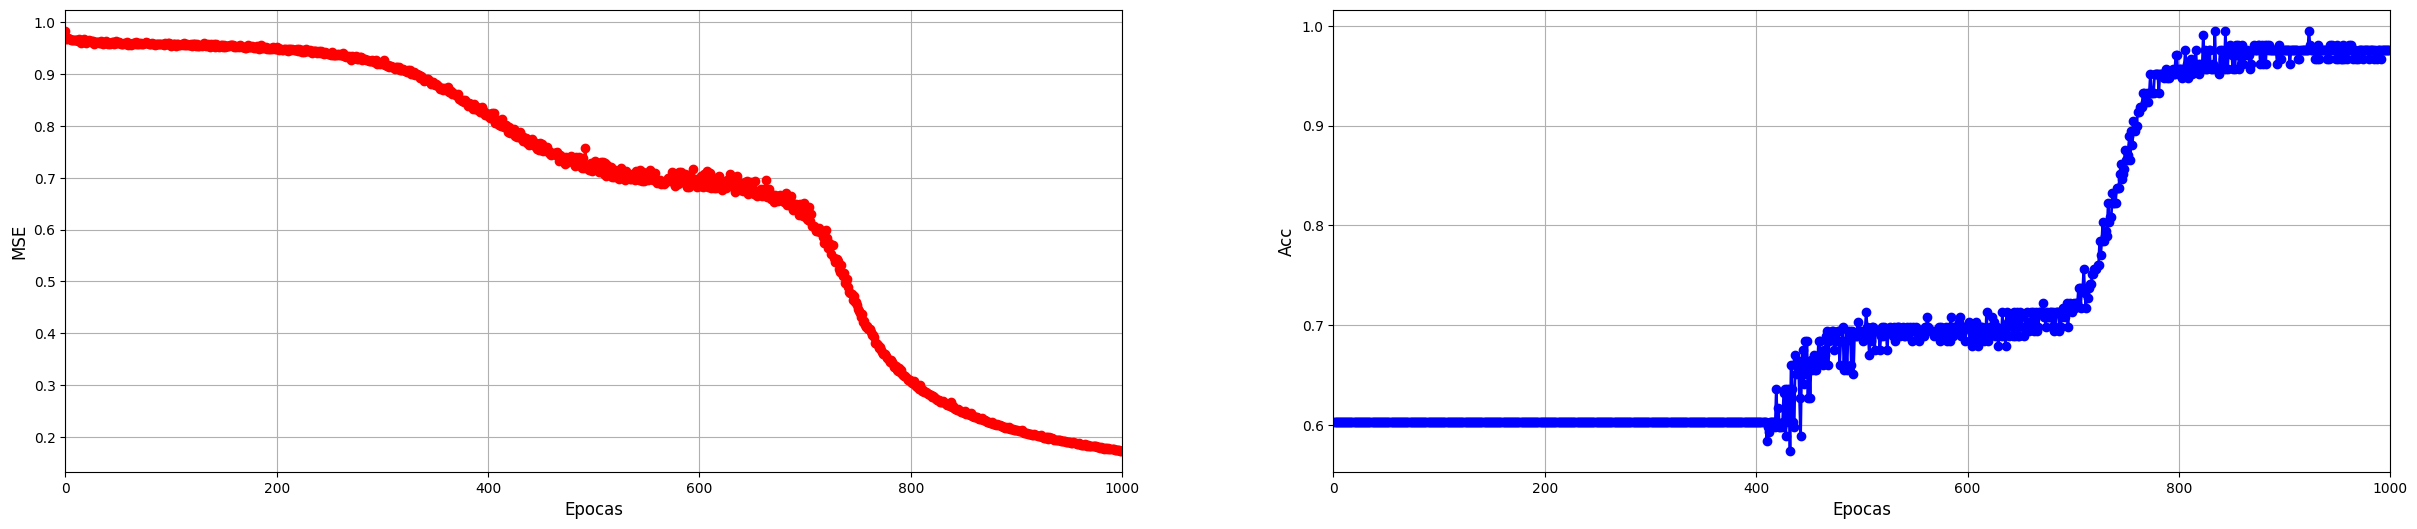

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(30,6))

epocas = np.arange(params["epoca"] )

# ERROR
ax[0].plot(epocas, error, 'o-r', lw=2)
ax[0].grid(True)
ax[0].set_xlim(0,params["MAX_EPOCAS"])
ax[0].set_xlabel('Epocas', fontsize=12)
ax[0].set_ylabel('MSE', fontsize=12)

# ACC
ax[1].plot(epocas, accuracy, 'o-b', lw=2)
ax[1].grid(True)
ax[1].set_xlim(0,params["MAX_EPOCAS"])
ax[1].set_xlabel('Epocas', fontsize=12)
ax[1].set_ylabel('Acc', fontsize=12)

# CLASIFICACION
Y_pred = Yp
C = []
for i in range(len(Y)):
    
    if (Y[i] == Y_pred[i]) and (Y[i] == 1):
        C.append('blue')
    if (Y[i] == Y_pred[i]) and (Y[i] == 0):
        C.append('red')
    if (Y[i] != Y_pred[i]) and (Y[i] == 1):
        C.append('cyan')
    if (Y[i] != Y_pred[i]) and (Y[i] == 0):
        C.append('magenta')
        